In [277]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import math
import matplotlib.pyplot as plt

ajouter des graphes, refaire fully adapted avec le truc de kalman

# In one dimension

In [278]:
def normal_density(x, mean = 0, sd = 1):
  return (1/math.sqrt(2*math.pi*sd**2))*math.exp(-0.5*(x-mean)**2*sd**2)

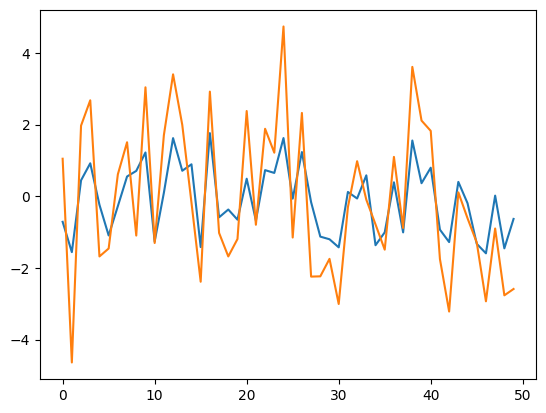

In [279]:
#simulate some data following a linear gaussian equation
x0 = npr.normal(0,1)
y0 = npr.normal(0,1)
T = 50
a = 0.1
b = 2
var_eps = 1
var_delta = 1

X = [x0]
Y = [y0]
Z = [[x0, y0]]
for t in range (1,T):
  X.append(a*X[t-1] + npr.normal(0,var_eps**2))
  Y.append(b*X[t] + npr.normal(0,var_delta**2))
  Z.append([X[t], Y[t]])

plt.plot(Z)

**kalman filter**

In [280]:
#implement the kalman filter
estimate_mu_x = [npr.normal(0,1)]
estimate_sigma_x = [npr.normal(0,1)]
res = [[estimate_mu_x[0], X[0]]]

def kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y):
  for t in range (1,len(Y)):
    estimate_mu_x.append(a*estimate_mu_x[t-1])
    estimate_sigma_x.append(a**2*estimate_sigma_x[t-1] + var_eps)
    estimate_mu_x[t] = estimate_mu_x[t] + estimate_sigma_x[t]*b*(Y[t]-b*estimate_mu_x[t-1])/(b**2*estimate_sigma_x[t] + var_delta)
    estimate_sigma_x[t] = estimate_sigma_x[t] - estimate_sigma_x[t]**2*b**2/(b**2*estimate_sigma_x[t] + var_delta)
    #print(estimate_mu_x[t], estimate_sigma_x[t])
    #x_values.append(npr.normal(estimate_mu_x[t], estimate_sigma_x[t]**2)) #maybe a problem here because I need to put it to square to avoid having negative sd
    res.append([estimate_mu_x[t], X[t]])
  return(res, estimate_mu_x, estimate_sigma_x)

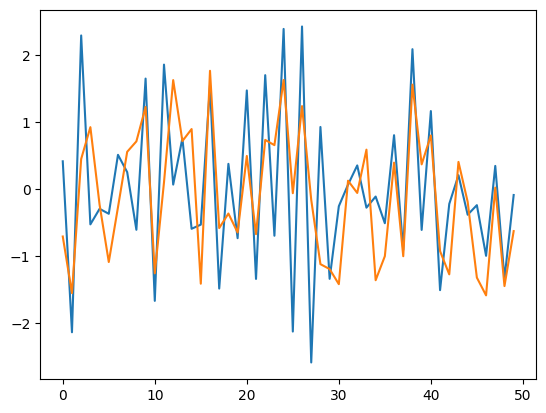

In [281]:
res = kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y)
to_plot = res[0]
x_values = res[1]
plt.plot(to_plot)

**Bootstrap PF**

In [282]:
#implement the bootstrap filter (smc)
def multinomial_resampling(w , x):
  u = npr.rand(*w.shape)
  bins = np.cumsum(w)
  return x[np.digitize(u, bins)]

def normal_density_vector(x, mean = 0, sd = 1):
    res = []
    for i in range (len(x)):
      res.append((1/math.sqrt(2*math.pi*sd**2))*math.exp(-0.5*(x[i]-mean)**2*sd**2))
    return (res)


def step(x_previous, weights_previous, Y_observed, a, var_eps, var_delta, b):
  #resample
  resample = multinomial_resampling(weights_previous, x_previous) #multinomial resampling of the particles
  #propagate
  x = np.array(npr.normal(a*resample,var_eps**2))
  #compute weights
  w = np.empty(len(x))
  for i in range (len(x)):
    w[i] = np.array(normal_density(Y_observed, mean = b*x[i], sd = var_delta**2))
  return (x, w, sum(w*x)/sum(w))


def bootstrap_filter(x, w, Y, a, var_eps, var_delta,b):
  estimate = [np.mean(smc_x[0])]
  res = []
  for t in range (1,len(Y)):
      res = step(x[t-1], w[t-1], Y[t], a, var_eps, var_delta,b)
      x[t] = np.array(res[0])
      w[t] = np.array(res[1])/sum(np.array(res[1])) #normalized weights
      #estimate
      estimate.append(res[2])
  return(x,w,estimate)


In [283]:
N = 3 #particles
T = 50
smc_x = np.empty([T,N])
smc_w = np.empty([T,N])
smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
smc_w[0] = np.array([[1/N for i in range (N)]])

#bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta) ok

In [284]:
res_smc = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)[2]

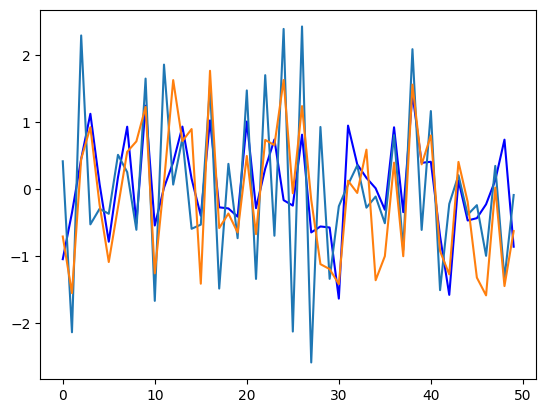

In [285]:
plt.plot(res_smc, color = 'blue')
plt.plot(to_plot)

Plot the particles behaviour

In [286]:
res = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)
particles = res[0]
estimate = res[2]

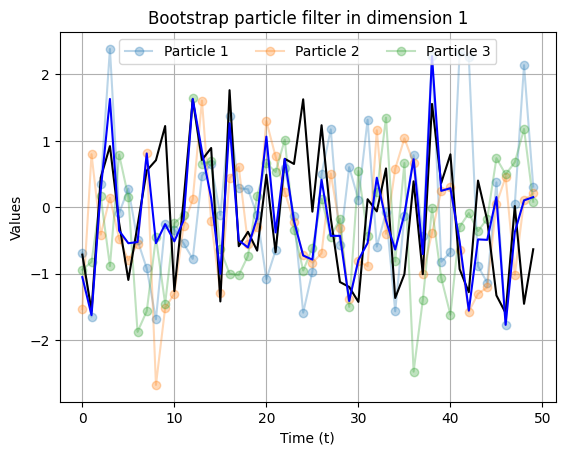

In [287]:
x_abs = np.array([i for i in range(T)])
for i in range(particles.shape[1]):
    plt.plot(x_abs, particles[:, i], 'o-', label='Particle {}'.format(i+1), alpha = 0.3)
plt.plot(X, color = 'black')
plt.plot(estimate, color = 'blue')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Bootstrap particle filter in dimension 1')
plt.legend(loc = 'upper center', ncols = 4)
plt.grid(True)
plt.show()

In [288]:
#weights
bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)[1]

array([[3.33333333e-01, 3.33333333e-01, 3.33333333e-01],
       [9.99932918e-01, 4.33680309e-11, 6.70818319e-05],
       [7.41286563e-06, 9.95655714e-01, 4.33687303e-03],
       [4.66764269e-10, 3.42709899e-05, 9.99965729e-01],
       [1.22654579e-01, 2.16027538e-02, 8.55742667e-01],
       [6.10242810e-01, 3.85905640e-01, 3.85155010e-03],
       [1.86315081e-01, 3.75915676e-01, 4.37769243e-01],
       [9.90062291e-01, 4.33120972e-08, 9.93766542e-03],
       [5.60772800e-01, 3.81954189e-01, 5.72730106e-02],
       [6.42705644e-02, 8.31372048e-04, 9.34898064e-01],
       [3.84981346e-04, 4.19077374e-01, 5.80537644e-01],
       [3.71477266e-03, 6.02850521e-04, 9.95682377e-01],
       [1.30726177e-03, 1.40923640e-02, 9.84600374e-01],
       [4.71364355e-01, 5.28373618e-01, 2.62027254e-04],
       [2.11333771e-01, 2.14864842e-01, 5.73801387e-01],
       [7.28740816e-03, 8.88039386e-01, 1.04673206e-01],
       [5.52955431e-02, 5.47888049e-01, 3.96816408e-01],
       [3.18975771e-01, 4.06470

Plot the difference between kalman and smc for increasing number of particles

In [289]:
def plot_kalman_smc_N(N, T, a, b, var_eps, var_delta):
  x0 = npr.normal(0,1)
  y0 = npr.normal(0,1)

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(a*X[t-1] + npr.normal(0,var_eps**2))
    Y.append(b*X[t] + npr.normal(0,var_delta**2))

  T = len(Y)
  absciss = np.array([i for i in range (N)])
  to_plot = []
  estimate_mu_x = [npr.normal(0,1)]
  estimate_sigma_x = [npr.normal(0,1)]
  res = [[estimate_mu_x[0], X[0]]]
  res = np.array(kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y)[1])
  for k in range (1, N):
    smc_x = np.empty([T,k])
    smc_w = np.empty([T,k])
    smc_x[0] = np.array([[npr.normal(0,1) for i in range (k)]]) #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/k for i in range (k)]])
    res_smc = np.array(bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)[2])

    RMSE = np.sqrt(np.mean((res_smc - res)**2))

    to_plot.append(RMSE)

  plt.plot(absciss[1:], to_plot)
  plt.xlabel('Number of particles')
  plt.ylabel('RMSE between the Kalman filter and the Bootstrap PF')
  plt.title('Convergence of the Bootstrap PF to the Kalman filter')
  plt.legend()
  plt.grid(True)
  plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


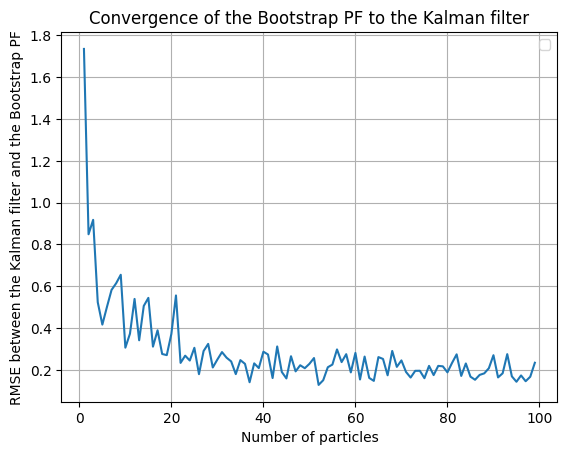

In [290]:
plot_kalman_smc_N(100, 10, 0.5, 0.75, 1, 1)

I average over 5 or 10 rounds for each N to have a more precise result

In [291]:
def boucle_average(n_rep, res, T, N, a, b, var_eps, var_delta, Y):
  to_return = []
  for i in range (n_rep):
    smc_x = np.empty([T,N])
    smc_w = np.empty([T,N])
    smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/N for i in range (N)]])
    res_smc = np.array(bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)[2])

    RMSE = np.sqrt(sum((res_smc - res)**2)/N)

    to_return.append(RMSE)

    return(np.mean(np.array(to_return)))


In [292]:
def plot_kalman_smc_N_2(N, T, a, b, var_eps, var_delta, n_rep):
  x0 = npr.normal(0,1)
  y0 = npr.normal(0,1)

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(a*X[t-1] + npr.normal(0,var_eps**2))
    Y.append(b*X[t] + npr.normal(0,var_delta**2))

  T = len(Y)
  absciss = np.array([i for i in range (N)])
  to_plot = []
  estimate_mu_x = [npr.normal(0,1)]
  estimate_sigma_x = [npr.normal(0,1)]
  res = [[estimate_mu_x[0], X[0]]]
  res = np.array(kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y)[1])
  for k in range (1, N):
    RMSE = boucle_average(n_rep, res, T, k, a, b, var_eps, var_delta, Y)

    to_plot.append(RMSE)

  plt.plot(absciss[1:], to_plot)
  plt.xlabel('Number of particles')
  plt.ylabel('RMSE between the Kalman filter and the Bootstrap PF')
  plt.title('Covergence of the Bootstrap PF to the Kalman filter')
  plt.legend()
  plt.grid(True)
  plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


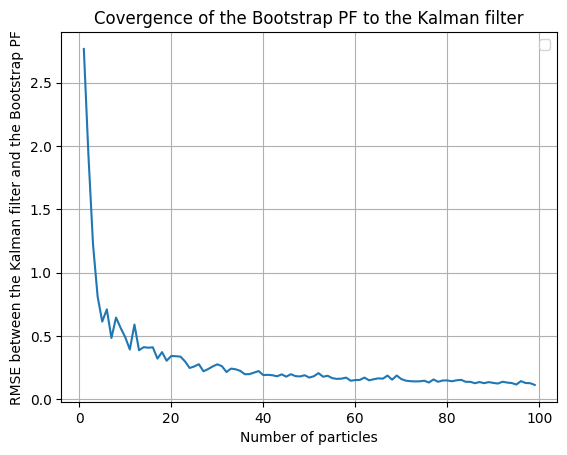

In [293]:
plot_kalman_smc_N_2(100, 10, 0.5, 0.75, 1, 1, 10)

**Fully adapted**

In [294]:
#TO DO

**Comparison for different values of T of Kalman and the particle filter**

In [295]:
def RMSE(sequence, true_values):
  return (np.sqrt(sum((sequence-true_values)**2)/len(sequence)))

In [296]:
#algorithm that does everything
def kalman_boostrap_simulate(T_max, N = 10, a = 0.7, b = 0.5, var_eps = 1, var_delta = 1, n_mean = 15):
  #arbitrarily initialize everything at 0
  RMSE_kalman = [0]
  RMSE_bootstrap = [0]
  res_boot = [0]
  res_kalman = [0]
  RMSE_kalman_for_round = []
  RMSE_boot_for_rounf = []

  #kalman filter and boostrap filter for each t
  for k in range (1, T_max):
    #simulate the true data
    x0 = npr.normal(0,1)
    y0 = npr.normal(0,1)
    X = [x0]
    Y = [y0]
    Z = [[x0, y0]]
    for t in range (1,k):
      X.append(a*X[t-1] + npr.normal(0,var_eps**2))
      Y.append(b*X[t] + npr.normal(0,var_delta**2))
      Z.append([X[t], Y[t]])

    #kalman and bootstrap for iteration k
    smc_x = np.empty([k,10])
    smc_w = np.empty([k,10])
    smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/N for i in range (N)]])

    estimate_mu_x = [npr.normal(0,1)]
    estimate_sigma_x = [npr.normal(0,1)]
    res = [[estimate_mu_x[0], X[0]]]

    res_kalman.append(kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y)[1])
    res_boot.append((bootstrap_filter(x = smc_x, w = smc_w, Y = Y, a = a, var_eps = var_eps, var_delta = var_delta, b=b))[2])

    RMSE_kalman.append(RMSE(np.array(res_kalman[k]), np.array(X)))
    RMSE_bootstrap.append(RMSE(np.array(res_boot[k]), np.array(X)))

  return (RMSE_kalman, RMSE_bootstrap) #warning : do not take the first value for each (initialized at 0)


In [297]:
to_plot = kalman_boostrap_simulate(50, a = 0.8, b = 0.7)

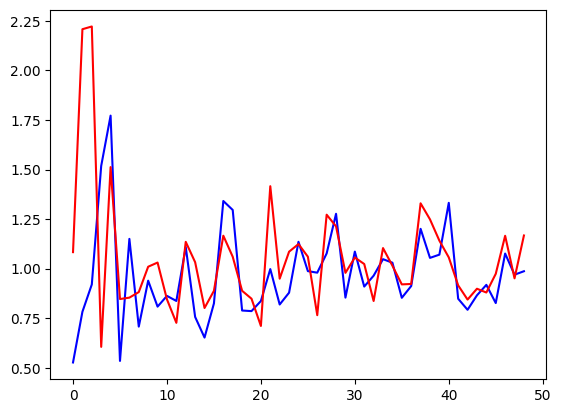

In [298]:
plt.plot(to_plot[0][1:], color = 'blue') #kalman
plt.plot(to_plot[1][1:], color = 'red') #PF

In [299]:
#algorithm that does everything
def kalman_boostrap_simulate_wip(T_max, N = 10, a = 0.7, b = 0.5, var_eps = 1, var_delta = 1, n_mean = 15):
  #arbitrarily initialize everything at 0
  RMSE_kalman = []
  RMSE_bootstrap = []
  res_boot = []
  res_kalman = []
  RMSE_kalman_for_round = []
  RMSE_boot_for_round = []

  #kalman filter and boostrap filter for each t
  for k in range (1, T_max):
    for z in range (n_mean):
      #simulate the true data
      x0 = npr.normal(0,1)
      y0 = npr.normal(0,1)
      X = [x0]
      Y = [y0]
      Z = [[x0, y0]]
      for t in range (1,k):
        X.append(a*X[t-1] + npr.normal(0,var_eps**2))
        Y.append(b*X[t] + npr.normal(0,var_delta**2))
        Z.append([X[t], Y[t]])

      #kalman and bootstrap for iteration k
      smc_x = np.empty([k,10])
      smc_w = np.empty([k,10])
      smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
      smc_w[0] = np.array([[1/N for i in range (N)]])

      estimate_mu_x = [npr.normal(0,1)]
      estimate_sigma_x = [npr.normal(0,1)]
      res = [[estimate_mu_x[0], X[0]]]

      res_kalman = kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y)[1]
      res_boot = bootstrap_filter(x = smc_x, w = smc_w, Y = Y, a = a, var_eps = var_eps, var_delta = var_delta, b=b)[2]

      RMSE_kalman_for_round.append(RMSE(np.array(res_kalman), np.array(X)))
      RMSE_boot_for_round.append(RMSE(np.array(res_boot), np.array(X)))

    RMSE_kalman.append(np.mean(np.array(RMSE_kalman_for_round)))
    RMSE_bootstrap.append(np.mean(np.array(RMSE_boot_for_round)))
    #RMSE_kalman.append(RMSE(np.array(res_kalman[k]), np.array(X)))
    #RMSE_bootstrap.append(RMSE(np.array(res_boot[k]), np.array(X)))
    res_boot = []
    res_kalman = []
    RMSE_kalman_for_round = []
    RMSE_boot_for_round = []

  return (RMSE_kalman, RMSE_bootstrap) #warning : do not take the first value for each (initialized at 0)


In [300]:
to_plot = kalman_boostrap_simulate_wip(30)

Text(0.5, 1.0, 'Average RMSE over 15 rounds for each value of T')

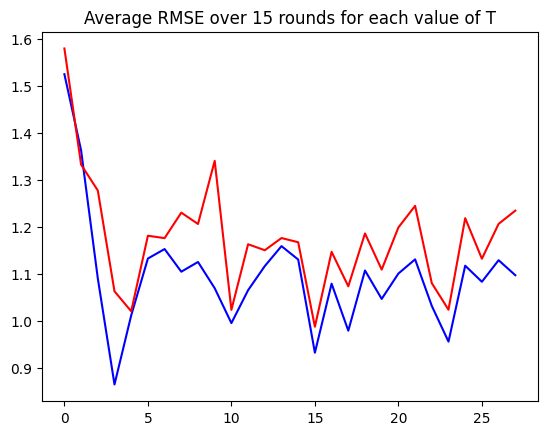

In [301]:
plt.plot(to_plot[0][1:], color = 'blue') #kalman
plt.plot(to_plot[1][1:], color = 'red') #PF
plt.title("Average RMSE over 15 rounds for each value of T")

In blue, the kalman filter RMSE, in red the bootstrap filer RMSE. In absciss, T the time.

# In dimension d

Let A the matrix such that $x_{t} = A x_{t-1} + \epsilon$. \
Let C the matrix such that $y_{t} = B x_{t} + \delta$.\
$\epsilon \sim N(0,Q)$ and $\delta \sim N(0,R)$.

initial belief : x and y $\sim N(0,1)$

**Data simulation**

In [302]:
#simulate data
D = 3 #dimension
#simulate some data following a linear gaussian equation
x0 = np.array([npr.normal(0,1) for i in range (D)])
y0 = np.array([npr.normal(0,1) for i in range (D)])
T = 50
A = 0.2*np.identity(D)
B = 0.4*np.identity(D)
var_eps = np.identity(D)
var_delta = np.identity(D)

X = [x0]
Y = [y0]
Z = [[x0, y0]]
for t in range (1,T):
  X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
  Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])
  Z.append([X[t], Y[t]])

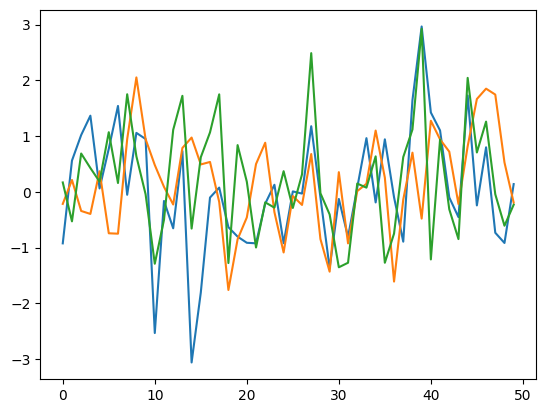

In [303]:
#plot the evolution of the coordinates of X and Y
plt.plot(np.array(X).transpose()[0])
plt.plot(np.array(X).transpose()[1])
plt.plot(np.array(Y).transpose()[0])

**Kalman filter**

In [304]:
#mu_x and sigma_x contain only the initial value
mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
sigma_x = np.array([np.identity(D)])

In [305]:
#kalman filter
def kalman_filter_d(mu_x, sigma_x, A, C, Q, R, true_Y, T):
  for t in range (1, T):
    #prediction
    mu_x = np.vstack([mu_x, (np.dot(A, mu_x[t-1]))])
    sigma_x = np.append(sigma_x, np.array([np.dot(np.dot(A, sigma_x[t-1]),A.transpose()) + Q]), axis= 0)
    #measurement update
    K = np.linalg.inv(np.array(np.dot(np.dot(C, sigma_x[t]), C.transpose()) + R))
    mu_x[t] = mu_x[t] + np.dot(np.dot(np.dot(sigma_x[t], C.transpose()), K), (true_Y[t] - np.dot(C, mu_x[t])))
    sigma_x[t] = sigma_x[t] - np.dot(np.dot(np.dot(np.dot(sigma_x[t], C.transpose()), K), C), sigma_x[t])
    #x_values = np.vstack([x_values,npr.multivariate_normal(mu_x[t], sigma_x[t])]) #useless
  return (mu_x, sigma_x)

**question à poser : dans ce site http://www.eie.polyu.edu.hk/~mwmak/EIE6207/KalmanFilter-beamer.pdf, ce que nous on appelle mu_t ils disent que c'est la prédiction de x_t. Dans le poly 'learning of dynamical systems', on utilise le x_t+1 mais ici on n'a pas accès à x_t+1. Donc j'ai tendance à dire qu'on est dans le cas 1 et que mu_x représente en réalité l'estimation de x à partir de z. sigma représente la variance de l'erreur de prédiction.**

In [306]:
res = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T)

In [307]:
mu_x = res[0]
sigma_x = res[1]

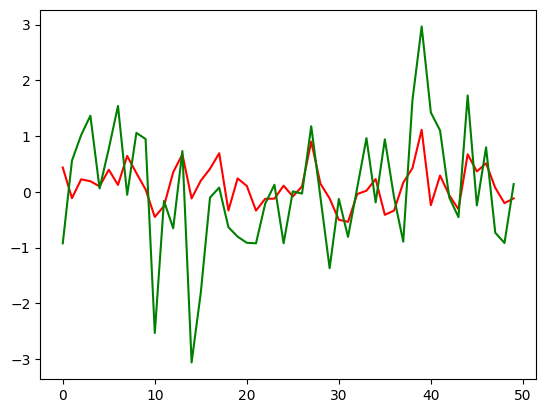

In [308]:
#plot the first coordinate of X and the estimations with the Kalman filter
plt.plot(mu_x.transpose()[0], color = 'red')
plt.plot(np.array(X).transpose()[0], color = 'green')

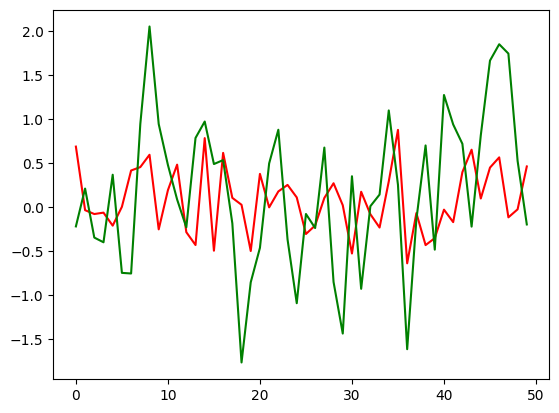

In [309]:
#plot the 2nd coordinate of X and the estimations with the Kalman filter
plt.plot(mu_x.transpose()[1], color = 'red')
plt.plot(np.array(X).transpose()[1], color = 'green')

red : kalman filter mean\
green : true values

**Bootstrap particle filter**

In [310]:
from scipy.stats import multivariate_normal
def normal_density_vector_d(x, mean, sd):
   return(multivariate_normal.pdf(x, mean = mean, cov= sd))

In [311]:
N = 10 #particles
smc_x = np.array([np.empty([D,N]) for i in range (T)])
smc_w = np.empty([T,N])
smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (N)]).transpose() #for each time we have N particles which have a value
smc_w[0] = np.array([[1/N for i in range (N)]])


In [312]:
#implement the bootstrap filter in high dimension
def multinomial_resampling_d(vectors, weights, num_samples):
    # Normalize weights
    normalized_weights = weights / np.sum(weights)
    # Resample indices
    indices = np.random.choice(np.arange(len(vectors)), size=num_samples, p=normalized_weights)
    # Resampled vectors
    resampled_vectors = vectors[indices]
    return resampled_vectors.transpose()


from scipy.stats import multivariate_normal
def normal_density_vector_d(x, mean, sd): #it works
   return(multivariate_normal.pdf(x, mean = mean, cov= sd))

def step_d(x_previous, weights_previous, Y_observed, A, var_eps, var_delta, D, N,B): #now we have matrices and vectors, D is the dimension, x_previous is going to be smc_x[t] for iteration t, Y_observed is Y[t]
  #resample #generate  xt-1^i_resampled equally weighted by resampling
  resample = multinomial_resampling_d(x_previous.transpose(),weights_previous, num_samples = N) #multinomial resampling of the particles
  #resample = x_previous #TO DO : multionimal resampling
  #propagate #sample xt^i from p(xt | xt-1^i_resampled)
  x = np.empty([D,N])
  for i in range(N):
    x[:,i] = np.array(np.dot(A, resample[:,i]) + npr.multivariate_normal(np.zeros(D), var_eps)) #creates an array for each i of dimension d
  #compute weights #p(yt|xt^i)
  w = np.empty(N)
  for i in range(N):
    w[i] = np.array(normal_density_vector_d(Y_observed, mean = np.dot(B,x[:,i]), sd = var_delta))
  w_norm = w/sum(w)
  #estimate
  estimate = np.array([0 for i in range (D)])
  for i in range(N):
    estimate = estimate + np.array(w_norm[i]*x[:,i]) #colonne de 3 ok
  return (x, w_norm, estimate)


In [313]:
def bootstrap_filter_d(x, w, Y, T, A, var_eps, var_delta, D, N,B):
  estimate = [np.zeros(D)] #valeurs de X donc ça doit être une collection de vecteurs de dimension d dans une matrice de dimension T
  res = []
  for t in range (1,T):
    res = step_d(x[t-1], w[t-1], Y[t], A, var_eps, var_delta, D, N,B)
    x[t] = np.array(res[0])
    w[t] = np.array(res[1]) #normalized weights
    estimate.append(res[2])
  return(x,w,estimate)

In [314]:
res = bootstrap_filter_d(smc_x, smc_w, Y, T, A, var_eps, var_delta, D, N,B)

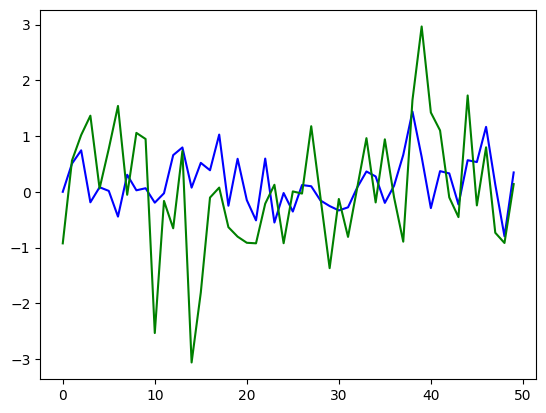

In [315]:
plt.plot(np.array(res[2]).transpose()[0], color = 'blue')
plt.plot(np.array(X).transpose()[0], color = 'green')

In blue : the boostrap PF, in green the real values of X. I only represented the first coordinate of X.

*Plot PF and Kalman filter results*

In [316]:
#algorithm that does everything in dimension D
def kalman_boostrap_simulate(T_max, D, N = 10, A = 0.2*np.identity(D), B = 0.4*np.identity(D), var_eps = np.identity(D), var_delta = np.identity(D)):
  #arbitrarily initialize everything at 0

  #simulate the true data
  x0 = np.array([npr.normal(0,1) for i in range (D)])
  y0 = np.array([npr.normal(0,1) for i in range (D)])
  X = [x0]
  Y = [y0]
  Z = [[x0, y0]]
  for t in range (1,T_max):
    X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
    Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])
    Z.append([X[t], Y[t]])

  #kalman and bootstrap
  smc_x = np.array([np.empty([D,N]) for i in range (T_max)])
  smc_w = np.empty([T_max,N])
  smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (N)]).transpose() #for each time we have N particles which have a value
  smc_w[0] = np.array([[1/N for i in range (N)]])

  mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
  sigma_x = np.array([np.identity(D)])
  x_values = np.array([x0])

  res_kalman = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T_max)
  res_boot = bootstrap_filter_d(smc_x, smc_w, Y, T_max, A, var_eps, var_delta, D, N,B)
  mu_kalman = res_kalman[0]
  sd_kalman = res_kalman[1]
  #values_kalman = res_kalman[0]
  values_boot = res_boot[2]
  particles = res_boot[0]

  return (mu_kalman, sd_kalman, values_boot, particles, X, Y)


In [317]:
D = 5
res = kalman_boostrap_simulate(30, D, N = 3, A = 0.2*np.identity(D), B = 0.4*np.identity(D), var_eps = np.identity(D), var_delta = np.identity(D))
mean = res[0]
sigma = res[1]
values_boot = res[2]
particles = res[3]
true_X = res[4]
true_Y = res[5]

plotting things... think of something better

In [318]:
for i in range (len(particles)): #len(particles) représente le temps
  print(particles[i][:,0]) #donne la colonne 0 cad le vecteur de la premiere particule avec ses D coordonnées
  print(particles[i][0]) #donnes les 10 particules sur la coordonnée 0

[ 0.47362561 -0.87966449 -0.46092208 -0.71895358 -0.38365874]
[ 0.47362561  2.93966765 -0.82234926]
[ 1.39738902 -0.23299163 -1.18022749  0.44428451 -2.08591019]
[ 1.39738902  1.31253953 -0.36096272]
[ 0.53171469 -1.55825661 -1.38806969  0.07324871 -0.39853692]
[ 0.53171469  0.7214391  -0.2662861 ]
[-0.66270371  0.98511145  0.07719929  0.99578308 -0.1874971 ]
[-0.66270371 -1.04437882 -1.20303101]
[-0.88049379 -0.64838566 -0.82064109  0.39121636 -1.29738607]
[-0.88049379 -1.41861493  0.99148854]
[-0.39841277 -0.97806642  0.99136506 -0.12918617 -0.41535296]
[-0.39841277 -1.87542172  1.27259598]
[ 0.61424867 -0.61583419 -1.63375551 -0.026099    1.80509534]
[ 0.61424867 -0.54651168 -1.72760534]
[-1.2474166  -1.02897261 -0.57206666  1.41723214 -0.68359446]
[-1.2474166  -0.39063274 -0.34156874]
[-0.24148774 -0.12065059  0.29853773  0.13302501 -0.6293549 ]
[-0.24148774 -0.70530386 -0.15521018]
[-0.07837695 -2.20418572 -0.65853655 -0.18547552  1.39625117]
[-0.07837695 -0.34213853  1.08099616]


In [319]:
#plotting the results for any coordinate
def plot_results(coordinate, particles, true_X, values_boot, sigma, mean):
  T = len(true_X)
  to_plot_coordinate = [particles[0][coordinate]]
  for i in range (1, len(particles)):
    to_plot_coordinate.append(particles[i][coordinate])
  to_plot_coordinate = np.array(to_plot_coordinate)

  x_abs = np.array([i for i in range(T)])
  for i in range(to_plot_coordinate.shape[1]):
    plt.plot(x_abs, to_plot_coordinate[:, i], 'o-', label='Particle {}'.format(i+1), alpha = 0.5)
  plt.plot(np.array(true_X).transpose()[1], color = 'red', label = 'True value of X')
  plt.plot(np.array(values_boot).transpose()[1], color = 'black', label = 'Estimated value of X with PF')
  #plt.plot(np.array(mean).transpose()[1], color = 'blue', label = 'Estimated mean Kalman')
  plt.errorbar(x_abs, np.array(mean).transpose()[1], yerr=sigma[:,1][:,1], fmt='o-', color = 'blue', label = 'Value and sd Kalman')
  plt.xlabel('Time (t)')
  plt.ylabel('Particles')
  plt.title('Coordinate {}'.format(coordinate+1))
  plt.legend()
  plt.grid(True)
  plt.show()


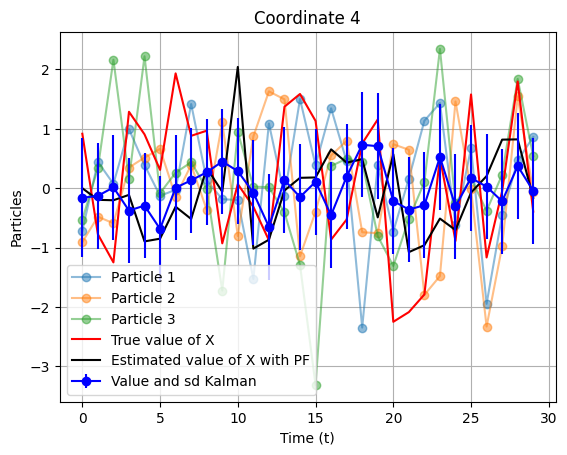

In [320]:
plot_results(3, particles, true_X, values_boot, sigma, mean)

In [321]:
#plotting the results for any coordinate
def plot_results_2(coordinate, particles, true_X, values_boot, sigma, mean):
  T = len(true_X)
  to_plot_coordinate = [particles[0][coordinate]]
  for i in range (1, len(particles)):
    to_plot_coordinate.append(particles[i][coordinate])
  to_plot_coordinate = np.array(to_plot_coordinate)

  x_abs = np.array([i for i in range(T)])
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  for i in range(to_plot_coordinate.shape[1]):
    axs[0].plot(x_abs, to_plot_coordinate[:, i], 'o-', label='Particle {}'.format(i+1), alpha = 0.3)
  axs[0].plot(np.array(true_X).transpose()[1], color = 'red', label = 'True value of X')
  axs[0].plot(np.array(values_boot).transpose()[1], color = 'black', label = 'Estimated value of X with PF',alpha = 0.7)
  axs[0].set_xlabel('Time (t)')
  axs[0].set_ylabel('Particles')
  axs[0].set_title('Coordinate {}'.format(coordinate+1))
  axs[0].legend()

  axs[1].plot(np.array(true_X).transpose()[1], color='red', label='True value of X')
  #plt.plot(np.array(mean).transpose()[1], color = 'blue', label = 'Estimated mean Kalman')
  axs[1].errorbar(x_abs, np.array(mean).transpose()[1], yerr=sigma[:,1][:,1], fmt='o-', color = 'blue', label = 'Value and sd Kalman', alpha = 0.3)
  axs[1].set_xlabel('Time (t)')
  axs[1].set_ylabel('Estimates')
  axs[1].set_title('Coordinate {}'.format(coordinate+1))
  axs[1].legend()

  plt.tight_layout()

  # Show the plot
  plt.show()


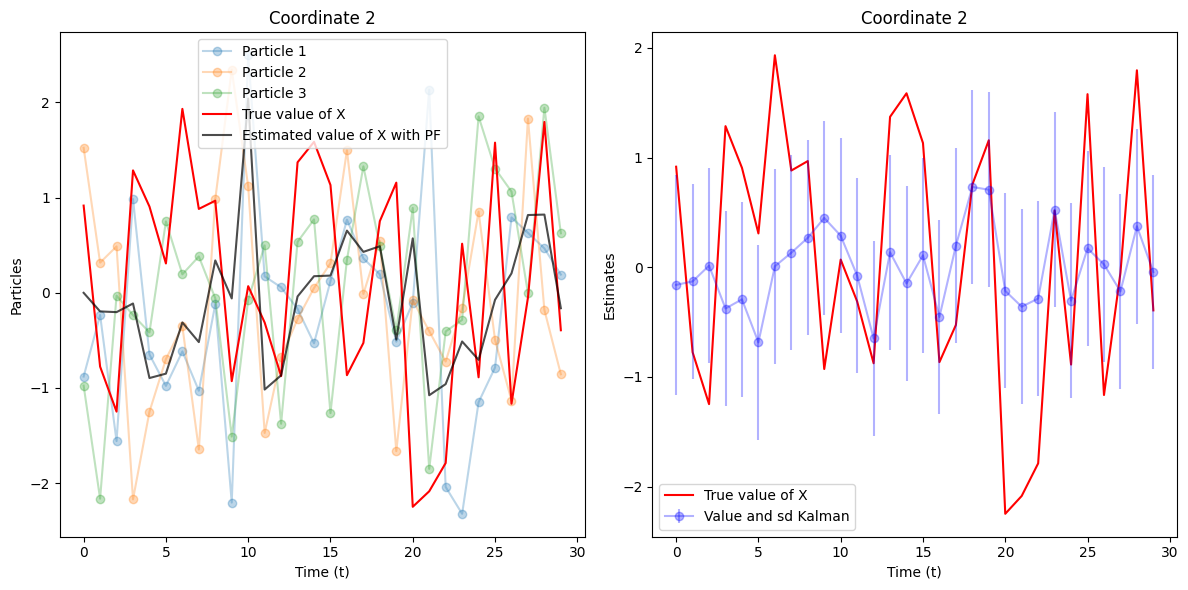

In [322]:
plot_results_2(1, particles, true_X, values_boot, sigma, mean)

Convergence of the BPF to the kalman filter

In [323]:
def RMSE(sequence, true_values):
  return (np.sqrt(sum((sequence-true_values)**2)/len(sequence)))

In [324]:
def RMSE_by_coordinate(seq1, seq2):
  D = len(seq1.transpose())
  T = len(seq1)
  res = []
  for i in range (D):
    res.append(RMSE(np.array(seq1).transpose()[i][1:], np.array(seq2).transpose()[i][1:]))
  return(res)

In [325]:
def plot_kalman_smc_N_dim_d(D, T, A, B, var_eps, var_delta, N):
  #simulate the data
  x0 = np.array([npr.normal(0,1) for i in range (D)])
  y0 = np.array([npr.normal(0,1) for i in range (D)])

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
    Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])

  absciss = np.array([i for i in range (N)])
  to_plot = []

  #kalman filter
  mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
  sigma_x = np.array([np.identity(D)])
  res = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T)
  mu_x = res[0]

  #smc for different values of N
  for k in range (1, N):
    smc_x = np.array([np.empty([D,k]) for i in range (T)])
    smc_w = np.empty([T,k])
    smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (k)]).transpose() #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/k for i in range (k)]])

    res_smc = bootstrap_filter_d(smc_x, smc_w, Y, T, A, var_eps, var_delta, D, k,B)[2]

    RMSE = RMSE_by_coordinate(mu_x, res_smc)

    to_plot.append(RMSE)

  to_plot = np.array(to_plot).transpose()
  for i in range(len(to_plot)): #len(to_plot) = D
    plt.plot(absciss[1:], to_plot[i], '-', label='Coordinate {}'.format(i+1), alpha = 0.5)
  plt.plot(absciss[1:], np.mean(to_plot, axis = 0), color = 'black')
  plt.xlabel('Number of particles')
  plt.ylabel('RMSE between the Kalman filter and the Bootstrap PF')
  plt.title('Convergence of the Bootstrap PF to the Kalman filter')
  plt.legend()
  plt.grid(True)
  plt.show()

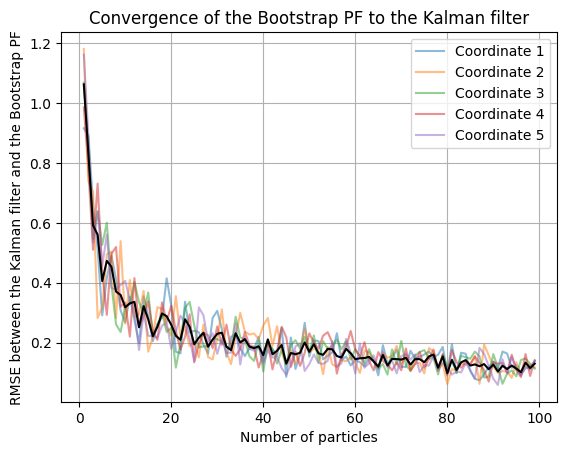

In [326]:
plot_kalman_smc_N_dim_d(5, 10, 0.2*np.identity(5), 0.4*np.identity(5), np.identity(5), np.identity(5), 100)

Again, we can average over several rounds to have a curve that is smoother

In [327]:
def boucle_kalman_smc_N_dim_d_average(mu_x, k, n_rep, Y, T, A, var_eps, var_delta, D, B):
  to_return = []
  for z in range (n_rep):
    smc_x = np.array([np.empty([D,k]) for i in range (T)])
    smc_w = np.empty([T,k])
    smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (k)]).transpose() #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/k for i in range (k)]])

    res_smc = bootstrap_filter_d(smc_x, smc_w, Y, T, A, var_eps, var_delta, D, k,B)[2]

    RMSE = RMSE_by_coordinate(mu_x, res_smc)
    to_return.append(RMSE)

  return(np.mean(np.array(to_return), axis = 0))


In [328]:
def plot_kalman_smc_N_dim_d_average(D, T, A, B, var_eps, var_delta, N, n_rep):
  #simulate the data
  x0 = np.array([npr.normal(0,1) for i in range (D)])
  y0 = np.array([npr.normal(0,1) for i in range (D)])

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
    Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])

  to_plot = []

  #kalman filter
  mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
  sigma_x = np.array([np.identity(D)])
  res = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T)
  mu_x = res[0]

  #smc for different values of N
  for k in range (1, N):
    RMSE = boucle_kalman_smc_N_dim_d_average(mu_x, k, n_rep, Y, T, A, var_eps, var_delta, D, B)

    to_plot.append(RMSE)

  to_plot = np.array(to_plot).transpose()
  return(to_plot)

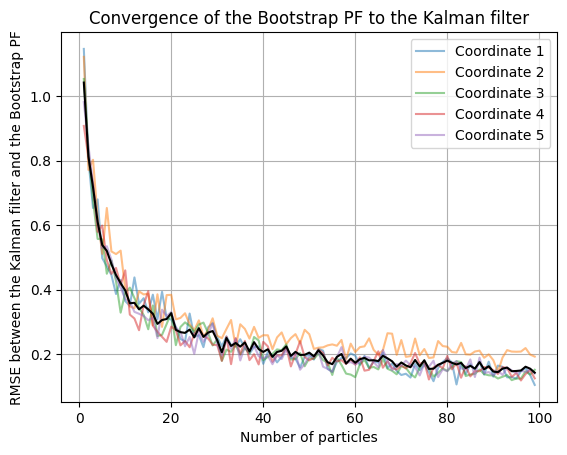

In [ ]:
to_plot = plot_kalman_smc_N_dim_d_average(5, 10, 0.2*np.identity(5), 0.4*np.identity(5), np.identity(5), np.identity(5), 100, 5)
absciss = np.array([i for i in range (100)])
for i in range(len(to_plot)): #len(to_plot) = D
    plt.plot(absciss[1:], to_plot[i], '-', label='Coordinate {}'.format(i+1), alpha = 0.5)
plt.plot(absciss[1:], np.mean(to_plot, axis = 0), color = 'black')
plt.xlabel('Number of particles')
plt.ylabel('RMSE between the Kalman filter and the Bootstrap PF')
plt.title('Convergence of the Bootstrap PF to the Kalman filter')
plt.legend()
plt.grid(True)
plt.show()

Change the noise level

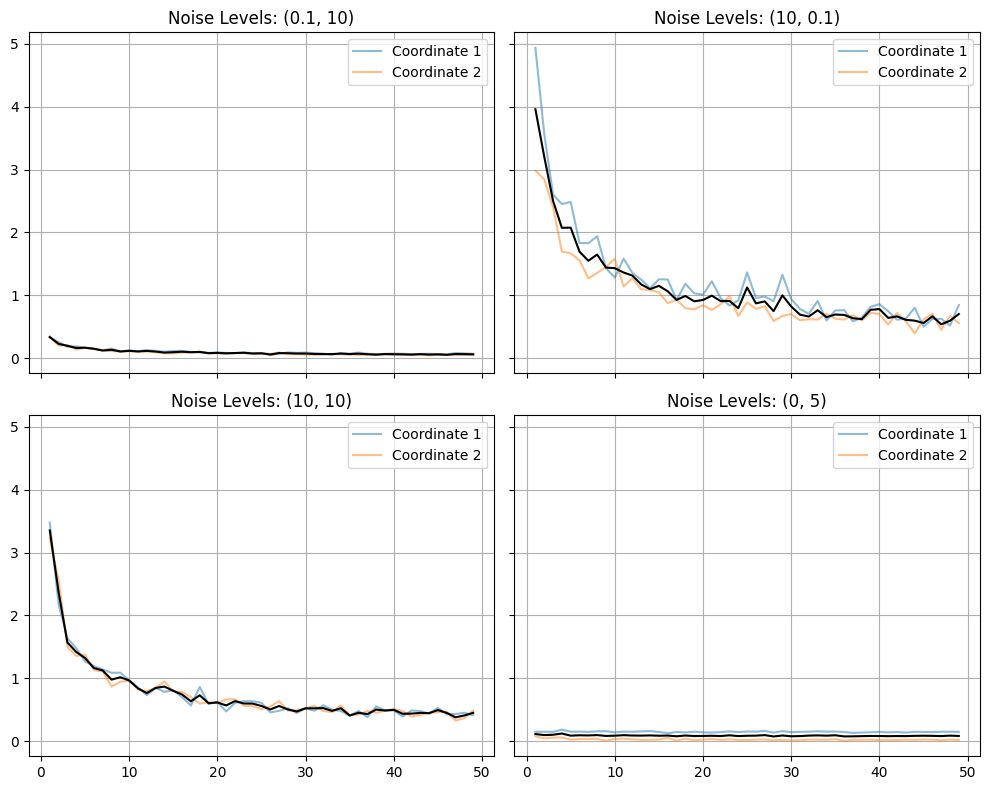

In [329]:
noise_levels = [[0.1, 10], [10, 0.1], [10, 10], [0, 5]]
N = 50
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
absciss = np.array([i for i in range (N)])

for i in range (len(noise_levels)):
  to_plot = plot_kalman_smc_N_dim_d_average(2, 10, 0.2*np.identity(2), 0.4*np.identity(2), noise_levels[i][0]*np.identity(2), noise_levels[i][1]*np.identity(2), N, 5)
  for z in range(len(to_plot)): #len(to_plot) = D
    axes[i // 2, i % 2].plot(absciss[1:], to_plot[z], '-', label='Coordinate {}'.format(z+1), alpha = 0.5)
  axes[i // 2, i % 2].plot(absciss[1:], np.mean(to_plot, axis = 0), color = 'black')
  noise_str = 'Noise Levels: ({}, {})'.format(noise_levels[i][0], noise_levels[i][1])
  axes[i // 2, i % 2].set_title(noise_str)
  axes[i // 2, i % 2].grid(True)
  axes[i // 2, i % 2].legend()

plt.tight_layout()
plt.show()

**Fully adapted SMC**

In [330]:
#kalman filter for the fapf
def kalman_filter_fapf_step(mu_x, sigma_x, A, C, Q, R, true_Y):
    #prediction
    mu_x_ = np.dot(A, mu_x)
    Pt_x_ = np.array(np.dot(np.dot(A, sigma_x),A.transpose()) + Q)
    #measurement update
    K = np.linalg.inv(np.array(np.dot(np.dot(C, sigma_x), C.transpose()) + R))
    mu_x_new = mu_x_ + np.dot(np.dot(np.dot(Pt_x_, C.transpose()), K), (true_Y - np.dot(C, mu_x_)))
    Pt_x_new = Pt_x_ - np.dot(np.dot(np.dot(np.dot(Pt_x_, C.transpose()), K), C), Pt_x_)
    return (mu_x_new, Pt_x_new)

q will correspond to the kalman filter

In [408]:
def p_ycurr_xcurr(y_current, x_current, B, R): #testé ok, good
    return([multivariate_normal.pdf(y_current, mean = np.dot(B, x_current[i]), cov= R) for i in range (len(x_current))])

def p_ycurr_xprev(y_current, x_previous, B, R, A, Q):
    return([multivariate_normal.pdf(y_current, mean = np.dot(B,np.dot(A, x_previous[i])), cov = np.dot(np.dot(B, Q), B.transpose()) + R) for i in range (len(x_previous))])

def p_xcurr_xprev(x_current, x_previous,A,Q):
    return([multivariate_normal.pdf(x_current[i], mean = np.dot(A, x_previous[i]) , cov = Q) for i in range (len(x_current))])

def q_xcurr_xprev_ycurr(x_current, x_previous, y_curr, A, B, Q, R, sigma_previous):
    values = []
    res = []
    for i in range (len(x_previous)):
        values = kalman_filter_fapf_step(x_previous[i], sigma_previous, A, B, Q, R, y_curr) #i do the kalman filter for each which gives me the new x and cov matrix
        res.append(multivariate_normal.pdf(x_current[i], mean = values[0], cov = values[1]))
    return(np.array(res))

def q_xcurr_xprev_ycurr_init(x_current, x_previous, y_curr, A, B, Q, R, sigma_previous):
    values = kalman_filter_fapf_step(x_previous, sigma_previous, A, B, Q, R, y_curr)
    return(np.array([multivariate_normal.pdf(x_current[i], mean = values[0], cov = values[1]) for i in range (len(x_current))]))

def w_function(p_yc_xc, p_yc_xp, p_xc_xp, q_xc_xp_yc):
    return(p_yc_xc*p_xc_xp/(p_yc_xp*q_xc_xp_yc)) #dans l'idée, voir les dimensions

    

In [419]:
def fully_adapted(x_0, true_Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, Q, R, N): #on donne x et y les valeurs à t=0, N nombre de particules qu'on veut
  #initialization
  D = np.shape(A)[0]
  T = len(true_Y)
  estimate = np.empty([T,D])
  x = np.empty([T, N, D])
  kalman_res = kalman_filter_fapf_step(x_0, np.identity(D), A, B, Q, R, true_Y[0])
  kalman_res_mean = np.array([kalman_res[0]])
  kalman_res_cov = np.array([kalman_res[1]])
  x[0] = np.array([npr.multivariate_normal(kalman_res_mean[0], kalman_res_cov[0], N)])
  w = np.empty([T, N])
  w[0] = np.array([p_ycurr_xcurr(true_Y[0], x[0], B, R)/np.array(q_xcurr_xprev_ycurr_init(x[0], x_0, true_Y[0], A, B, Q, R, np.identity(D)))])
  w[0] = w[0]/sum(w[0]) #normalize weights
  nu = np.empty([T, N]) #adjustment multipliers
  estimate[0] = x_0

  #for loop
  for t in range (1, T):
    #adjustement multipliers
    nu[t-1] = np.array(p_ycurr_xprev(true_Y[t], x[t-1], B, R, A, Q)) 
    #resample
    weights = [nu[t-1][i]*w[t-1][i] for i in range (N)] #nouveaux weights pour cette étape
    weights = weights/sum(weights)
    resample = multinomial_resampling_d(x[t-1], weights, N).transpose() #on a N particules
    #propagate
    for i in range (len(resample)):
      kalman_res = kalman_filter_fapf_step(resample[i], np.identity(D), A, B, Q, R, true_Y[t])
      #kalman_res = np.append(kalman_res, np.array([kalman_filter_fapf_step(resample[i], kalman_res[t-1][i], A, B, Q, R, true_Y[t]) for i in range (len(resample))]))
      x[t][i] = npr.multivariate_normal(kalman_res[0], kalman_res[1],1) 
    #weight
    p_yc_xc = np.array(p_ycurr_xcurr(Y[t], x[t], B, R))
    p_yc_xp = np.array(p_ycurr_xprev(Y[t], x[t], B, R, A, Q))
    p_xc_xp = np.array(p_xcurr_xprev(x[t], x[t-1],A,Q))
    q_xc_xp_yc = np.array(q_xcurr_xprev_ycurr(x[t], x[t-1], Y[t], A, B, Q, R, np.identity(D)))
    w[t] = w_function(p_yc_xc, p_yc_xp, p_xc_xp, q_xc_xp_yc) #calculer le ratio : mais ici ya des choses qui se simplifient et on a seulement p(y[t]|x[t]^i)
    w[t] = w[t]/sum(w[t])
    #w[t] = [1 for i in range (N)] #fapf you have weights equal to one : very strange
    #estimate the value
    estimate[t] = np.dot(w[t], x[t])

  return(x,w,estimate)


In [411]:
#simulate data
D = 3 #dimension
#simulate some data following a linear gaussian equation
x0 = np.array([npr.normal(0,1) for i in range (D)])
y0 = np.array([npr.normal(0,1) for i in range (D)])
T = 50
A = 0.2*np.identity(D)
B = 0.4*np.identity(D)
var_eps = np.identity(D)
var_delta = np.identity(D)

X = [x0]
true_Y = [y0]
for t in range (1,T):
  X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
  true_Y.append(np.dot(B, X[t-1]) + [npr.normal(0,1) for i in range (D)])

N = 10
x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))


In [420]:
res = fully_adapted(x_0, true_Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, N)

In [421]:
values_boot = res[2]
particles = res[0]
true_X = X

In [422]:
np.shape(particles) #good

(50, 10, 3)

In [423]:
#plotting the results for any coordinate
def plot_results_fully(coordinate, particles, true_X, values_boot):
  T = len(true_X)
  to_plot_coordinate = [particles[0].transpose()[coordinate]]
  for i in range (1, len(particles)):
    to_plot_coordinate.append(particles[i].transpose()[coordinate])
  to_plot_coordinate = np.array(to_plot_coordinate)

  x_abs = np.array([i for i in range(T)])
  for i in range(to_plot_coordinate.shape[1]):
    plt.plot(x_abs, to_plot_coordinate[:, i], 'o-', label='Particle {}'.format(i+1), alpha = 0.5)
  plt.plot(np.array(true_X).transpose()[1], color = 'red', label = 'True value of X')
  plt.plot(np.array(values_boot).transpose()[1], color = 'black', label = 'Estimated value of X with the Fully APF')
  #plt.plot(np.array(mean).transpose()[1], color = 'blue', label = 'Estimated mean Kalman')
  #plt.errorbar(x_abs, np.array(mean).transpose()[1], yerr=sigma[:,1][:,1], fmt='o-', color = 'blue', label = 'Value and sd Kalman')
  plt.xlabel('Time (t)')
  plt.ylabel('Particles')
  plt.title('Coordinate {}'.format(coordinate+1))
  plt.legend()
  plt.grid(True)
  plt.show()


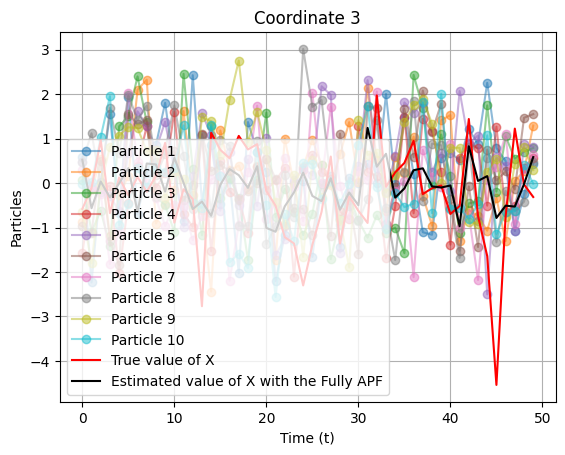

In [424]:
plot_results_fully(2, particles, true_X, values_boot)

In [ ]:
seems ok

comparer avec kalman pour voir si les résultats sont justes: car fredrik a dit que ct pareil que de faire kalman

*Plot the results for Kalman, PF, Fully APF*

In [ ]:
def RMSE(matrix_1, matrix_2):
    T = len(matrix_1[0])
    D = len(matrix_1)
    res = np.empty([D,T]) #on veut RMSE pour chaque t et chaque coordonnée
    for i in range (D):
        for t in range (T):
            
        

In [466]:
def compare_kalman_pf_fapf(d, D, T, A, B, var_eps, var_delta, N, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function):
    #simulate the data 
    x0 = np.array([npr.normal(0,1) for i in range (D)])
    y0 = np.array([npr.normal(0,1) for i in range (D)])

    X = [x0]
    Y = [y0]
    for t in range (1,T):
        X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
        Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])
    
    X = np.array(X).transpose()

    #kalman filter 
    mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
    sigma_x = np.array([np.identity(D)])
    res = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T)
    mu_x = np.array(res[0]).transpose()

    #bootstrap filter
    smc_x = np.array([np.empty([D,N]) for i in range (T)])
    smc_w = np.empty([T,N])
    smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (N)]).transpose() #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/N for i in range (N)]])
    res_boot = np.array(bootstrap_filter_d(smc_x, smc_w, Y, T, A, var_eps, var_delta, D, N,B)[2]).transpose()

    #APF
    x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))
    res_apf = np.array(fully_adapted(x_0, Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, N)[2]).transpose()
    
    #compute the RMSE compared with the true values for each method 
    #RMSE_kalman = 
    #RMSE_smc = RMSE_by_coordinate(mu_x, res_smc)
    #RMSE_apf = RMSE_by_coordinate(mu_x, res_smc)
    

    x_abs = [i for i in range (T)]
    plt.plot(x_abs[1:], X[d][1:], label = 'X')
    plt.plot(x_abs[1:], mu_x[d][1:], label = 'Kalman')
    plt.plot(x_abs[1:], res_boot[d][1:], label = 'BPF')
    plt.plot(x_abs[1:], res_apf[d][1:], label = 'FAPF')
    plt.legend()
    plt.title('Coordinate {}'.format(d+1))
    plt.grid(True)


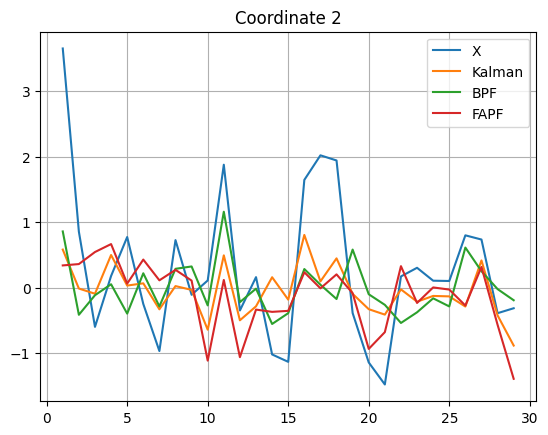

In [468]:
compare_kalman_pf_fapf(1, 3, 30, A, B, var_eps, var_delta, 10, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function)

FAPF doesn't appear to be the best... let's plot the RMSE depending on the number of particles considered to see

**Nested smc**

# Annexes

In [ ]:
#def q(x_current, x_previous, y_current, A, Q): #testé ok, not the good
  #return([multivariate_normal.pdf(np.array(x_current[i]), mean = np.array(np.dot(A, x_previous)), cov= Q) for i in range (len(x_current))])

#def q_bis(x_current, x_previous, y_current, A, Q): #testé ok
  #return([multivariate_normal.pdf(np.array(x_current[i]), mean = np.array(np.dot(A, x_previous[i])), cov= Q) for i in range (len(x_current))])

def p_y_x(y_current, x_current, B, R): #testé ok, good
  return([multivariate_normal.pdf(y_current, mean = np.dot(B, x_current[i]), cov= R) for i in range (len(x_current))])

def p_x_x(x_current, x_previous, A, Q): #testé ok
  return([multivariate_normal.pdf(x_current[i], mean = np.dot(A, x_previous[i]), cov= Q) for i in range (len(x_current))])

def w_function(resampled_previous, x_current, y_current, A, B, Q, R): #testé ok
  denom = q_bis(x_current, resampled_previous, y_current, A, Q)
  res_x_y = p_y_x(y_current, x_current, B, R)
  res_x_x = p_x_x(x_current, resampled_previous, A, Q)
  num = np.array(res_x_y)*np.array(res_x_x)
  if denom!=0:
    return (num/denom)
  else :
    return ('Erreur')


In [ ]:
def fully_adapted(x_0, true_Y, p_x_x, p_y_x, w_function, q, A, B, Q, R, N): #on donne x et y les valeurs à t=0, N nombre de particules qu'on veut
  #initialization
  D = np.shape(A)[0]
  T = len(true_Y)
  estimate = np.empty([T,D])
  x = np.empty([T, N, D])
  x[0] = np.array([npr.multivariate_normal(np.dot(np.dot(B,A),x_0), np.dot(np.dot(B, Q),B) + R, N)]) #particles (donc x_1)
  w = np.empty([T, N])
  w[0] = np.array([p_y_x(true_Y[0], x[0],B,R)/np.array(q(x[0], x_0, true_Y[0],A,Q))]) #to do : add mu 
  w[0] = w[0]/sum(w[0]) #normalize weights
  nu = np.empty([T, N]) #adjustment multipliers
  estimate[0] = [x_0]

  #for loop
  for t in range (1, T):
    #adjustement multipliers
    nu[t-1] = np.array(p_y_x(np.array(true_Y[t]), np.array(x[t-1]), B, R)) #ok
    #resample
    weights = [nu[t-1][i]*w[t-1][i] for i in range (N)] #nouveaux weights pour cette étape
    resample = multinomial_resampling_d(x[t-1], weights, N).transpose() #on a N particules
    #propagate
    for i in range (len(x[t])):
      x[t][i] = npr.multivariate_normal(np.dot(A,resample[i]),Q,1) #problem : to change 
    #weight
    w[t] = w_function(resample, x[t], true_Y[t], A, B ,Q, R) #calculer le ratio : mais ici ya des choses qui se simplifient et on a seulement p(y[t]|x[t]^i)
    w[t] = w[t]/sum(w[t])
    #estimate the value
    estimate[t] = np.dot(w[t], x[t])

  return(x,w, estimate)
